In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
import FCMA as f
import importlib
import quadpy
from scipy.special import erf
from scipy.integrate import quad_vec
f = importlib.reload(f)

%matplotlib notebook

LF1: 
$$-logL(\boldsymbol{\theta}|\boldsymbol{x}) = -\sum_i^N log(P(x_i|\boldsymbol{\theta}))$$

$$-logL(\boldsymbol{\theta}|\boldsymbol{x}) = -\int_{x \in \Omega_x} log(P(x|\boldsymbol{\theta}))\sum_i^N PDF(x|x_i,\theta_{x_i})dx$$

LF2: $$-logL(\boldsymbol{\theta}|\boldsymbol{x}) =-\sum_i^N log\left(\int_{x \in \Omega_x} P(x|\boldsymbol{\theta})PDF(x|x_i,\theta_{x_i})dx \right)$$
(should the derivation include a normalization?)

# Firstly the trial 1d case:

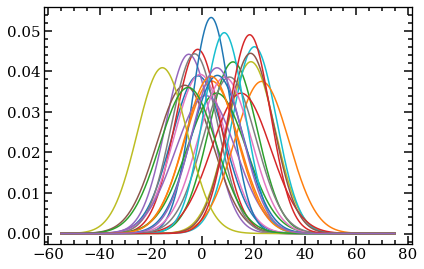

In [41]:
N = 25

sigmas = np.abs(np.random.normal(10,1,N))
mus = np.random.normal(5,10,N)

minimum = -55
maximum = 75
x = np.linspace(minimum,maximum,1000)

fig, ax = plt.subplots()
ax.plot(x,f.gauss(x,mus,sigmas));

In [42]:
LF1_1d, LF2_1d = f.return_losses_1d(mus,sigmas,(minimum,maximum))

obj1 = f.integratedLH(LF1_1d)
M1 = Minuit(obj1,mu=5,sigma=4)

obj2 = f.integratedLH(LF2_1d)
M2 = Minuit(obj2,mu=5,sigma=4,limit_sigma=(0,None))

In [43]:
M1.migrad()

------------------------------------------------------------------
| FCN = 101.1                   |      Ncalls=66 (66 total)      |
| EDM = 3.61e-10 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |    5.7    |    2.8    |            |            |         |         |       |
| 1 | sigma |   13.8    |    2.0    |            |            |         |         |       |
-------------------------------------------------------------------------------------------

In [44]:
M2.migrad()

------------------------------------------------------------------
| FCN = 92.5                    |      Ncalls=37 (37 total)      |
| EDM = 2.28e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |    6.1    |    2.0    |            |            |         |         |       |
| 1 | sigma |     2     |     4     |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

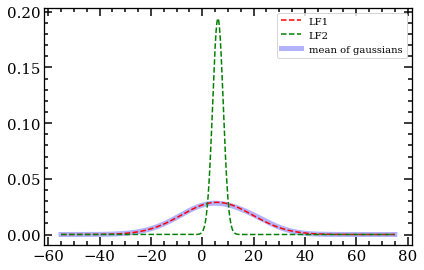

In [45]:
fig, ax = plt.subplots()
ax.plot(x,f.gauss(x,*M1.args),'r--',label='LF1')
ax.plot(x,f.gauss(x,*M2.args),'g--',label='LF2')
ax.plot(x,f.gauss(x,mus,sigmas).mean(1),'b-',zorder=-1,alpha=0.3,linewidth=5, label='mean of gaussians')

plt.legend()

# (Other 1d trial)

In [12]:
def wrapper(mus, sigmas, lim):
    def gauss(x,mu,sigma):
        x = np.asarray(x).reshape(-1,1)
        mu = np.expand_dims(mu,0)
        sigma = np.expand_dims(sigma,0)
        return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

    def P_1d(x,mu,sigma,f):
        norm = 2*lim - f*sigma*np.sqrt(2*np.pi)*erf(lim/(np.sqrt(2)*sigma))
        return (1 - gauss(x,mu,sigma)*f*(sigma*np.sqrt(2*np.pi)))/norm
    
    def LF2_1d(mu, sigma, f):
#         def integrand(x):
#             return 
#         print(quadpy.quad(lambda x: P_1d(x,mu,sigma,f).T*gauss(x,mus,sigmas).T,-lim,lim)[0])
#         vals = quadpy.quad(lambda x: P_1d(x,mu,sigma,f).T*gauss(x,mus,sigmas).T,-lim,lim)[0]
        vals = P_1d(mus,mu,sigma,f)
        return -np.sum(np.log(vals))
    return LF2_1d, P_1d

(0, 0.06)

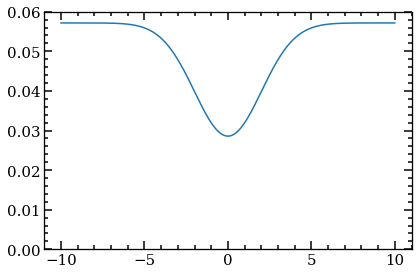

In [13]:
lim = 10
N = 50

tmp, P_1d = wrapper(0,0,lim)

x = np.linspace(-lim,lim,1000)
mu, sigma, frac = 0, 2, 0.5
signal = P_1d(x,mu,sigma,frac)

fig, ax = plt.subplots()
ax.plot(x,signal)
ax.set_ylim(0,0.06)

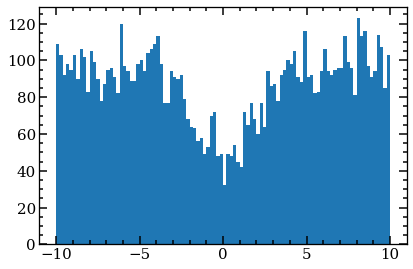

In [14]:
def MCsample(func,xlims,ylims,N_ish):
    Ux = np.random.uniform(*xlims,N_ish)
    Uy = np.random.uniform(*ylims,N_ish)
    return Ux[Uy<=func(Ux).flatten()]

mus = MCsample(lambda Ux: P_1d(Ux,mu,sigma,frac),(-lim,lim),(0,signal.max()),10000)
sigmas = np.random.uniform(0.5,1,mus.shape[0])

fig, ax = plt.subplots()
ax.hist(mus,bins=100);
# ax.plot(x,f.gauss(x,mus,sigmas));

In [15]:
LF2_1d, P_1d = wrapper(mus,sigmas,lim)
obj2 = f.integratedLH(LF2_1d)
M2 = Minuit(obj2,mu=0,sigma=1,f=1,limit_f=(0,1))

In [16]:
M2.migrad()

------------------------------------------------------------------
| FCN = 2.589e+04               |     Ncalls=113 (113 total)     |
| EDM = 2.21e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |    0.1    |    0.1    |            |            |         |         |       |
| 1 | sigma |   -1.75   |   0.12    |            |            |         |         |       |
| 2 | f     |   0.513   |   0.023   |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

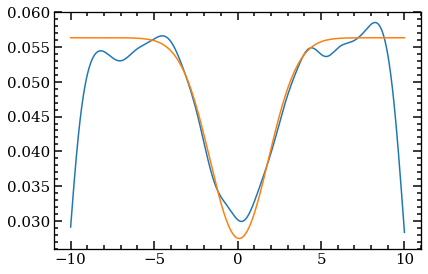

In [17]:
fig, ax = plt.subplots()
ax.plot(x,f.gauss(x,mus,sigmas).mean(1))
ax.plot(x,P_1d(x,*M2.args))

# Secondly the trial 2d case (however, only for LF1):

In [298]:
lim = 8
N = 100000
bins=100

xy = np.random.uniform(-lim,lim,(N,2))
sigmas = np.random.uniform(0.3,0.5,N)
r_sqrd = xy[:,0]**2 + xy[:,1]**2

mask = r_sqrd <= lim**2
xy = xy[mask]
sigmas = sigmas[mask]
r_sqrd = r_sqrd[mask]

sigma = 1
w = 1 + 2*np.exp(-0.5*r_sqrd/sigma**2)/(2*np.pi*sigma**2)

<IPython.core.display.Javascript object>


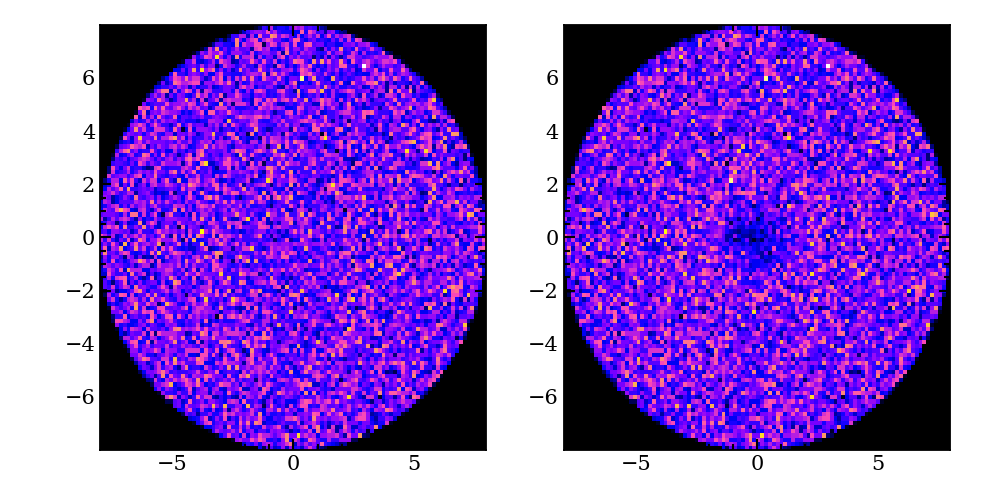

<IPython.core.display.Javascript object>


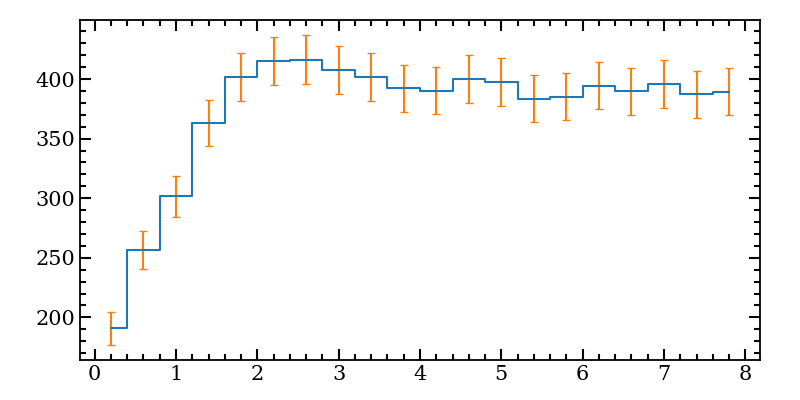

<ErrorbarContainer object of 3 artists>

In [299]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(xy[:,0],xy[:,1],bins=bins)
ax[1].hist2d(w*xy[:,0],w*xy[:,1],bins=bins);

fig, ax = plt.subplots()
vals, binedges = np.histogram(w*np.sqrt(r_sqrd),bins=20,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = f.binc(binedges)

ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')

In [300]:
N_samples = 2**6+1
int_lim = 8
LF1_2d, P_2d, P_obs, (X_grid,Y_grid), (X,Y) = f.return_LF1_2d_and_P_2d(xy*w.reshape(-1,1),sigmas,N_samples, int_lim)

100%|██████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]


In [29]:
obj1 = f.integratedLH(LF1_2d)
M1 = Minuit(obj1,mu_x=0,mu_y=0,sigma=1,f=1, 
            limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None),limit_f=(0,1))

In [71]:
M1.migrad()

------------------------------------------------------------------
| FCN = 2.759e+04               |     Ncalls=144 (144 total)     |
| EDM = 2.51e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |    0.3    |    1.2    |            |            |   -5    |    5    |       |
| 1 | mu_y  |   -0.2    |    1.5    |            |            |   -5    |    5    |       |
| 2 | sigma |    0.9    |    0.6    |            |            |    0    |         |       |
| 3 | f     |   0.08    |   0.10    |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


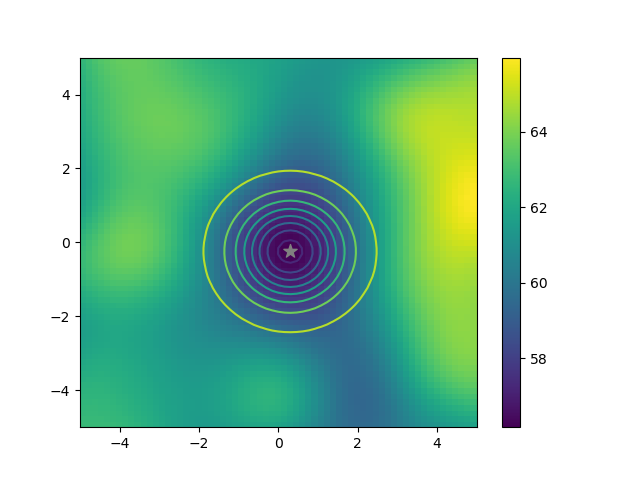

In [75]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid, P_obs.reshape(N_samples,N_samples))
ax.scatter(M1.args[0],M1.args[1],c='grey',marker='*',s=100,zorder=10)

h_loss = P_2d(X.flatten(),Y.flatten(),*M1.args)
ax.contour(X,Y,h_loss.reshape(N_samples,N_samples))
fig.colorbar(im)

<IPython.core.display.Javascript object>


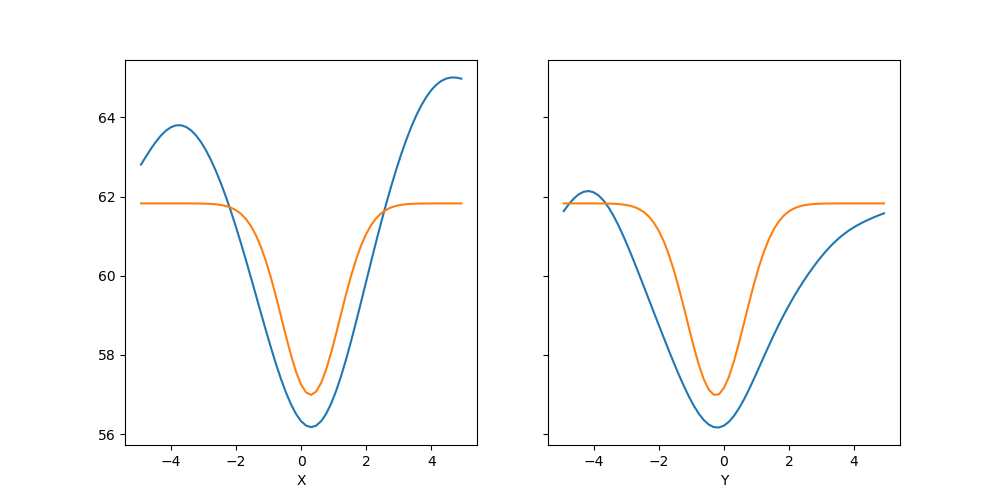

In [129]:
loc = (M1.values['mu_x'],M1.values['mu_y'])
row = np.abs(Y-loc[1]).argmin(0)[0]
col = np.abs(X-loc[0]).argmin(1)[0]

fig, ax = plt.subplots(figsize=(10,5),ncols=2,sharey=True)
tmp = P_obs.reshape(N_samples,N_samples)
ax[0].set_xlabel('X')
ax[0].plot(X[row,:],tmp[row,:])
ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M1.args)*(4*int_lim**2 - M1.values['f']*M1.values['sigma']**2*2*np.pi)*tmp.mean())
ax[1].set_xlabel('Y')
ax[1].plot(Y[:,col],tmp[:,col])
ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M1.args)*(4*int_lim**2 - M1.values['f']*M1.values['sigma']**2*2*np.pi)*tmp.mean());

Possibly include a picture like:
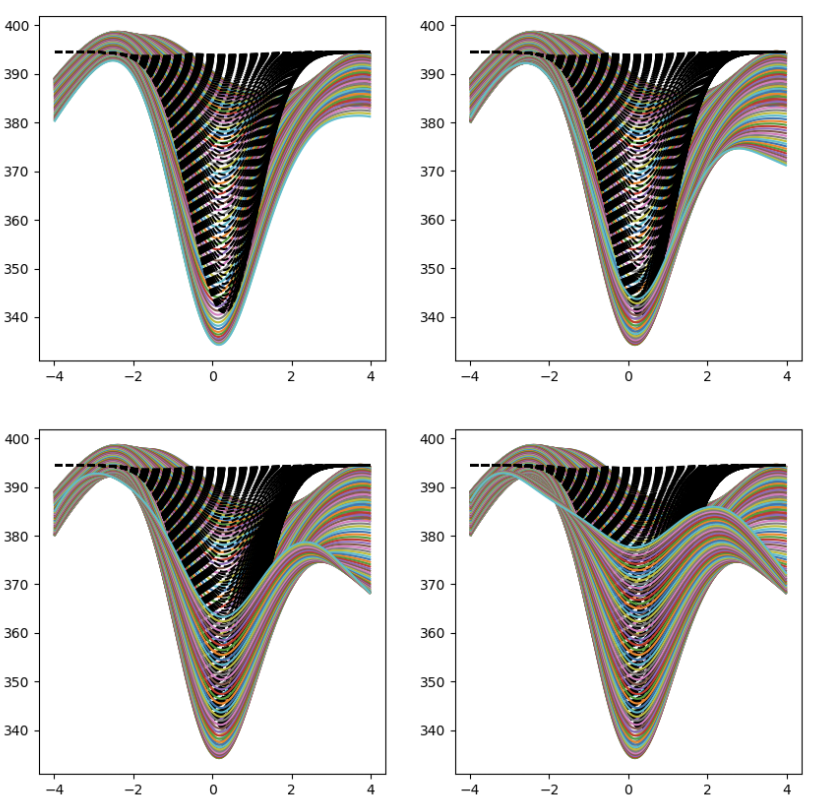

# Using LF2 (takes too long):

In [142]:
LF2_2d, P_2d = f.return_LF2_2d_and_P_2d(xy*w.reshape(-1,1),sigmas,int_lim)
obj2 = f.integratedLH(LF2_2d)
M2 = Minuit(obj2,mu_x=0,mu_y=0,sigma=1,f=0.1, 
            limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None),limit_f=(0,1))

In [143]:
M2.migrad()

14:24:11 - Called
14:26:36 - Returning Loss
14:26:36 - Called
14:28:59 - Returning Loss
14:28:59 - Called


RuntimeError: exception was raised in user function
User function arguments:
     mu_x = -0.100000
     mu_y = +0.000000
    sigma = +1.000000
        f = +0.999999
Original python exception in user function:
KeyboardInterrupt: 
  File "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\FCMA.py", line 40, in __call__
    return self.f(*par)
  File "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\FCMA.py", line 119, in LF2_2d
    loss = -np.sum(np.log(quad_vec(lambda y: quad_vec(lambda x: P_2d(x,y,mu_x,mu_y,sigma,f)*(gauss2d(x,y,xy_reco,xy_sigma)),-lim,lim)[0],-lim,lim)[0]))
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 356, in quad_vec
    for dint, derr, dround_err, subint, dneval in mapwrapper(_subdivide_interval, to_process):
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 415, in _subdivide_interval
    s2, err2, round2 = _quadrature(c, b, f, norm_func)
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 569, in _quadrature_gk21
    return _quadrature_gk(a, b, f, norm_func, x, w, v)
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 470, in _quadrature_gk
    ff = f(c + h*x[i])
  File "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\FCMA.py", line 119, in <lambda>
    loss = -np.sum(np.log(quad_vec(lambda y: quad_vec(lambda x: P_2d(x,y,mu_x,mu_y,sigma,f)*(gauss2d(x,y,xy_reco,xy_sigma)),-lim,lim)[0],-lim,lim)[0]))
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 356, in quad_vec
    for dint, derr, dround_err, subint, dneval in mapwrapper(_subdivide_interval, to_process):
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 415, in _subdivide_interval
    s2, err2, round2 = _quadrature(c, b, f, norm_func)
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 569, in _quadrature_gk21
    return _quadrature_gk(a, b, f, norm_func, x, w, v)
  File "C:\Users\jv97\anaconda3\lib\site-packages\scipy\integrate\_quad_vec.py", line 470, in _quadrature_gk
    ff = f(c + h*x[i])
  File "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\FCMA.py", line 119, in <lambda>
    loss = -np.sum(np.log(quad_vec(lambda y: quad_vec(lambda x: P_2d(x,y,mu_x,mu_y,sigma,f)*(gauss2d(x,y,xy_reco,xy_sigma)),-lim,lim)[0],-lim,lim)[0]))
  File "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\FCMA.py", line 64, in gauss2d
    z_sqrd = (((xy - mus)/sigmas)**2).sum(1)


# Try to implement quadpy

In [301]:
# quadpy.c2.schemes
for i in range(25):
    try:
        scheme = quadpy.s2.get_good_scheme(i)
#         plt.figure()
#         scheme.show()
        print(i, scheme.points.shape)
    except:
        print(i, "None")

0 (2, 1)
1 (2, 1)
2 (2, 4)
3 (2, 4)
4 (2, 6)
5 (2, 7)
6 (2, 12)
7 (2, 12)
8 (2, 19)
9 (2, 19)
10 (2, 28)
11 (2, 28)
12 (2, 36)
13 (2, 36)
14 (2, 44)
15 (2, 44)
16 (2, 57)
17 (2, 57)
18 (2, 72)
19 (2, 72)
20 None
21 None
22 None
23 None
24 None


In [367]:
scheme = quadpy.s2.get_good_scheme(19) #c2

def wrapper(xy_reco, xy_sigma, lim):
    
    def gauss2d(x,y,mus,sigmas):
        xy = (np.vstack((x,y,)).T).reshape(-1,2,1)
        mus = mus.T.reshape(1,2,-1)
        sigmas = sigmas.reshape(1,-1)

        z_sqrd = (((xy - mus)/sigmas)**2).sum(1)
        return np.exp(-0.5*z_sqrd)/(2*np.pi*sigmas**2)
    
    def P_2d(x,y,mu_x,mu_y,sigma,f):
        z_sqrd = ((x-mu_x)**2 + (y - mu_y)**2)/ sigma**2
#         return 1/(4*lim**2 - f*sigma**2*2*np.pi)*(1 - f*np.exp(-0.5*z_sqrd))
        norm = 4*lim**2 - 2*np.pi*f*sigma**2*erf(lim/(np.sqrt(2)*sigma))**2
#         norm = scheme.integrate(lambda x_y: 1 - f*np.exp(-0.5*((x_y[0]-mu_x)**2 + (x_y[1] - mu_y)**2)/ sigma**2),[0.0,0.0],lim)
#         norm = scheme.integrate(lambda x_y: 1 - f*np.exp(-0.5*((x_y[0]-mu_x)**2 + (x_y[1] - mu_y)**2)/ sigma**2),np.array([[[-lim, -lim], [lim, -lim]], [[-lim, lim], [lim, lim]]]))
        return (1 - f*np.exp(-0.5*z_sqrd))/norm
    
    def calc_weights():
        x, y = xy_reco[:,0], xy_reco[:,1]
        r = np.sqrt(x**2 + y**2)
        w = np.ones(r.shape[0])
#         mask = r > lim
        mask = (x > -lim)&(x < lim)&(y > -lim)&(y < lim)
        w[mask] = 0
#         w[mask] = np.exp(-0.5*((r[mask]-lim)/xy_sigma[mask])**2)#/(2*np.pi*xy_sigma[mask]**2)
#         w = scheme.integrate(lambda x_y: gauss2d(x_y[0],x_y[1],xy_reco,xy_sigma).T,[0.0,0.0],lim)
#         w = scheme.integrate(lambda x_y: gauss2d(x_y[0],x_y[1],xy_reco,xy_sigma).T,np.array([[[-lim, -lim], [lim, -lim]], [[-lim, lim], [lim, lim]]]))
#         w = quadpy.quad(lambda x_y: gauss2d(x_y[0],x_y[1],xy_reco,xy_sigma).T, [-lim,-lim],[lim,lim])
        return w
    
    weights = calc_weights()
    
    def LF2_2d(mu_x,mu_y,sigma,f):
        def integrand(x_y):
            x, y = x_y
            tmp = P_2d(x,y,mu_x,mu_y,sigma,f).T*gauss2d(x,y,xy_reco,xy_sigma).T
            return tmp
#         vals = scheme.integrate(integrand,np.array([[[-lim, -lim], [lim, -lim]], [[-lim, lim], [lim, lim]]]))
#         vals = scheme.integrate(integrand)
#         print(quadpy.quad(lambda x: integrand((x,np.zeros(x.shape[0]))),-lim,lim)[0].shape)
#         vals = quadpy.quad(lambda x: integrand((x[0],x[1])),(-lim,-lim),(lim,lim))[0]
        vals = P_2d(xy_reco[:,0],xy_reco[:,1],mu_x,mu_y,sigma,f)
#         vals = scheme.integrate(integrand,[0.0,0.0],lim)
#         loss = -np.sum(np.log(vals))
        loss = -np.sum(weights*np.log(vals))/np.sum(weights)
#         print(loss, mu_x, mu_y, sigma, f, vals.min(), vals.max())
        return loss
    return LF2_2d, P_2d, weights

In [368]:
int_lim = 4
LF2_2d, P_2d, weights = wrapper(xy*w.reshape(-1,1),sigmas,int_lim)
obj2 = f.integratedLH(LF2_2d)
M2 = Minuit(obj2,mu_x=0,mu_y=0,sigma=10,f=0.6, 
            limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None),limit_f=(0,1),
            fix_sigma=False,fix_f=False)

In [374]:
# scheme.integrate(lambda x_y: P_2d(x_y[0],x_y[1],0,0,100,0.5),[0.0,0.0],4)
quadpy.quad(lambda x_y: P_2d(x_y[0],x_y[1],0,0,100,0.5), [-int_lim,-int_lim],[int_lim,int_lim])

(0.1767766852522553, 2.529532724384184e-19)

<IPython.core.display.Javascript object>


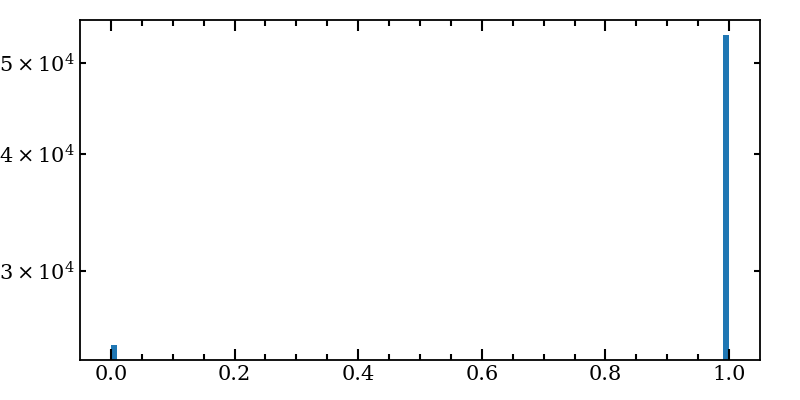

In [369]:
# %matplotlib notebook
fig, ax = plt.subplots()
ax.hist(weights,bins=100);
ax.set_yscale('log')

In [370]:
M2.migrad()

------------------------------------------------------------------
| FCN = 2.753                   |     Ncalls=360 (360 total)     |
| EDM = 8.09e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |    -4     |     7     |            |            |   -4    |    4    |       |
| 1 | mu_y  |     4     |     7     |            |            |   -4    |    4    |       |
| 2 | sigma |    0e3    |    5e3    |            |            |    0    |         |       |
| 3 | f     | 1000.0e-3 |  0.5e-3   |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


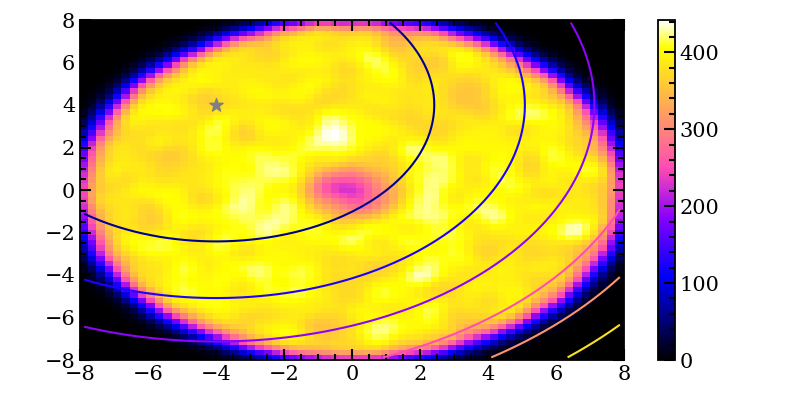

In [371]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid, P_obs.reshape(N_samples,N_samples))
ax.scatter(M2.args[0],M2.args[1],c='grey',marker='*',s=100,zorder=10)

h_loss = P_2d(X.flatten(),Y.flatten(),*M2.args)
ax.contour(X,Y,h_loss.reshape(N_samples,N_samples))
fig.colorbar(im)

<IPython.core.display.Javascript object>


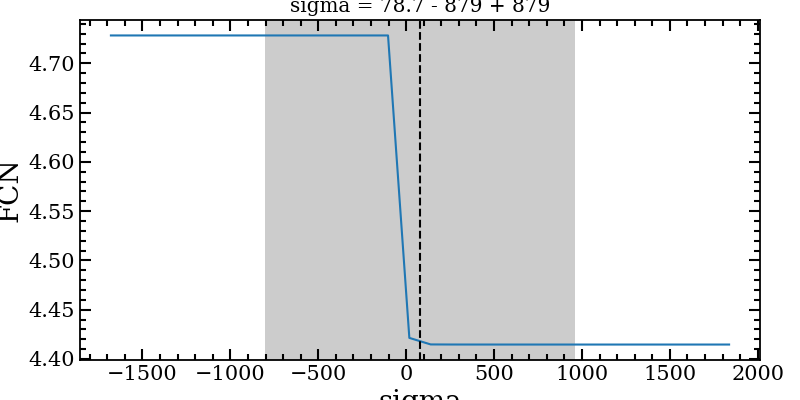

C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitWarning: MIGRAD fails to converge for sigma=-1679.607263
  
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitWarning: MIGRAD fails to converge for sigma=-1558.348082
  
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitWarning: MIGRAD fails to converge for sigma=-1437.088900
  
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitWarning: MIGRAD fails to converge for sigma=-1315.829718
  
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitWarning: MIGRAD fails to converge for sigma=-1194.570537
  
C:\Users\jv97\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitW

(array([-1679.60726348, -1558.34808176, -1437.08890004, -1315.82971833,
        -1194.57053661, -1073.3113549 ,  -952.05217318,  -830.79299147,
         -709.53380975,  -588.27462804,  -467.01544632,  -345.75626461,
         -224.49708289,  -103.23790117,    18.02128054,   139.28046226,
          260.53964397,   381.79882569,   503.0580074 ,   624.31718912,
          745.57637083,   866.83555255,   988.09473426,  1109.35391598,
         1230.61309769,  1351.87227941,  1473.13146113,  1594.39064284,
         1715.64982456,  1836.90900627]),
 array([4.72824882, 4.72824882, 4.72824882, 4.72824882, 4.72824882,
        4.72824882, 4.72824882, 4.72824882, 4.72824882, 4.72824882,
        4.72824882, 4.72824882, 4.72824882, 4.72824882, 4.4213475 ,
        4.41471578, 4.41463211, 4.41461185, 4.41460356, 4.41460205,
        4.41459879, 4.41460026, 4.41459707, 4.41459661, 4.41459729,
        4.41460252, 4.41459635, 4.41459899, 4.41459556, 4.41460528]))

In [338]:
plt.figure()
M2.draw_mnprofile('sigma')
# help(M2.draw_mncontour)

<IPython.core.display.Javascript object>


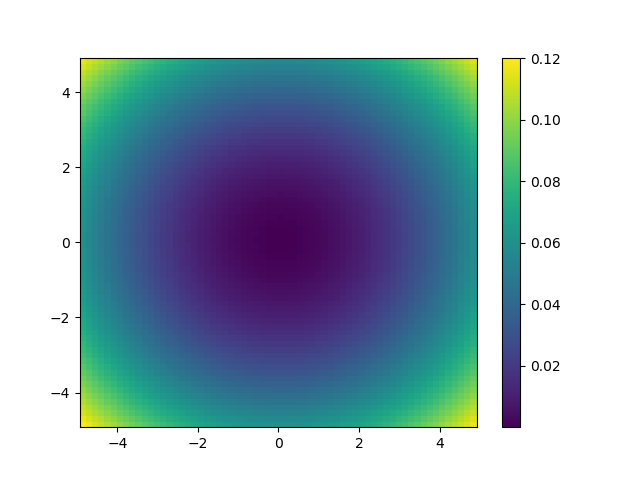

<IPython.core.display.Javascript object>


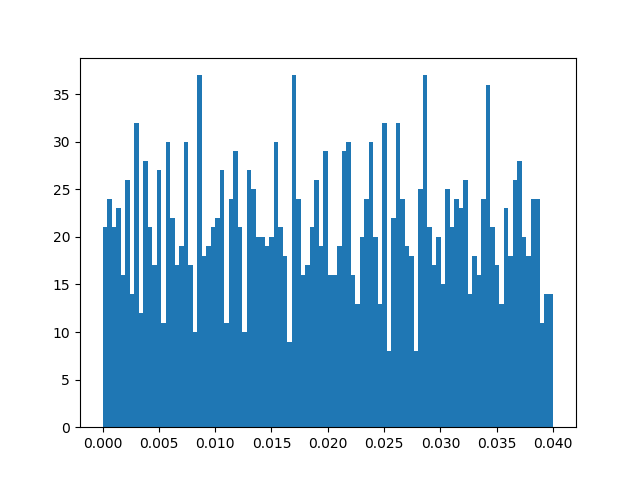

41.985685329670446

In [62]:
fig, ax = plt.subplots()
# h_loss = P_2d(X.flatten(),Y.flatten(),0,0,1,0.5)
h_loss = P_2d(X.flatten(),Y.flatten(),*M2.args)
im = ax.pcolormesh(X,Y,h_loss.reshape(N_samples,N_samples))
fig.colorbar(im)

mask = np.sqrt(X**2 + Y**2) <= int_lim
fig, ax = plt.subplots()
ax.hist(h_loss[mask.flatten()],bins=100);
h_loss[mask.flatten()].sum()

<IPython.core.display.Javascript object>


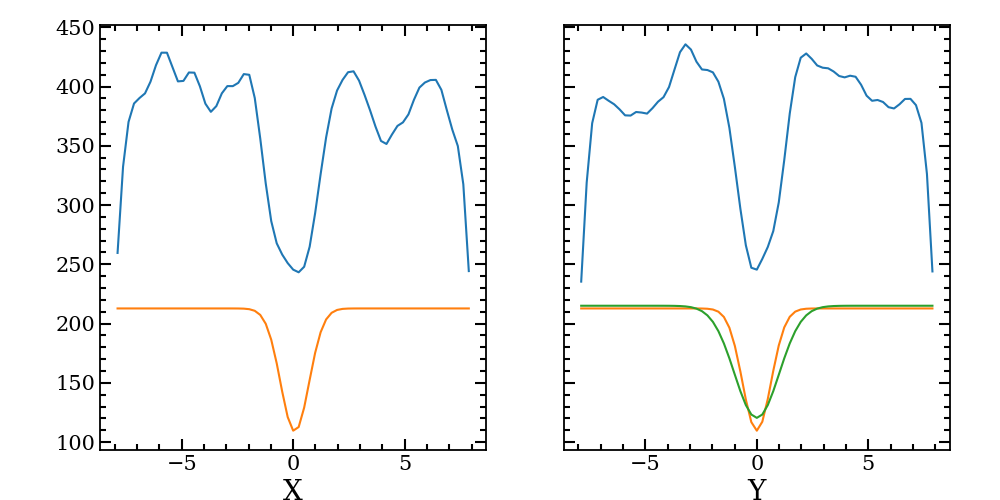

In [245]:
loc = (M2.values['mu_x'],M2.values['mu_y'])
row = np.abs(Y-loc[1]).argmin(0)[0]
col = np.abs(X-loc[0]).argmin(1)[0]

norm = scheme.integrate(lambda x_y: 1 - M2.values['f']*np.exp(-0.5*((x_y[0]-M2.values['mu_x'])**2 + (x_y[1] - M2.values['mu_y'])**2)/ M2.values['sigma']**2),[0.0,0.0],int_lim)
# norm = scheme.integrate(lambda x_y: 1 - M2.values['f']*np.exp(-0.5*((x_y[0]-M2.values['mu_x'])**2 + (x_y[1] - M2.values['mu_y'])**2)/ M2.values['sigma']**2),np.array([[[-int_lim, -int_lim], [int_lim, -int_lim]], [[-int_lim, int_lim], [int_lim, int_lim]]]))


fig, ax = plt.subplots(figsize=(10,5),ncols=2,sharey=True)
tmp = P_obs.reshape(N_samples,N_samples)
ax[0].set_xlabel('X')
ax[0].plot(X[row,:],tmp[row,:])
# ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M2.args)*(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi*erf(int_lim/(np.sqrt(2)*M2.values['sigma']))**2)*tmp.mean())
ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M2.args)*tmp.mean()*100);
ax[1].set_xlabel('Y')
ax[1].plot(Y[:,col],tmp[:,col])
# ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M2.args)*(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi*erf(int_lim/(np.sqrt(2)*M2.values['sigma']))**2)*tmp.mean());
ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M2.args)*tmp.mean()*100);
ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],0,0,1,0.44)*tmp.mean()*100);